In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:

def grayscale(img):
    #Applies the Grayscale transform
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    ysize, xsize, _ = img.shape
    rightLineX = []
    leftLineX = []
    
    rightLineY = []
    leftLineY = []
    
    i = 0
    
    
    for index, val in enumerate(lines):
        #print('--')
        #print(val)
        for x1,y1,x2,y2 in val:

            m = ((y2-y1)/(x2-x1))
            #print(m)
            #print(x1,',', xsize/2)
            
            if m > 0.5 and x1 > xsize/2:
                rightLineX += (x1, x2)
                rightLineY += (y1, y2)
            elif m < -0.5 and x1 < xsize/2:
                leftLineX += (x1, x2)
                leftLineY += (y1, y2)
    
    #print(rightLineX)
    #print('---------------')
    #print(rightLineY)
    #print('-------LEFT--------')
    #print(leftLineX)
    #print('---------------')
    #print(leftLineY)        
    
    mRight, rightB = np.polyfit(rightLineX, rightLineY, 1)
    mLeft, leftB = np.polyfit(leftLineX, leftLineY, 1)

    ymin = 0.70*ysize
    rightLine = (int((ysize - rightB)/mRight), int(ysize), int((ymin- rightB)/mRight), int(ymin))            
    leftLine = (int((ysize - leftB)/mLeft)+10, int(ysize), int((ymin- leftB)/mLeft), int(ymin))
    
    #print(rightLine)
    #print('----------------')
    #print(leftLine)
    
    for x1, y1, x2, y2 in (rightLine, leftLine):
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return lines,line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):

    return cv2.addWeighted(initial_img, α, img, β, λ)

def process_image(image): #Lane lines detection pipeline

    imshape = image.shape
    pXmax=imshape[1]
    pYmax=imshape[0]
    
    #Defining ROI vertices and selecting ROI in image
    yMin=pYmax/2+35
    yMax=pYmax
    roi=[(100,yMax),(pXmax/2-15, yMin), (pXmax/2+25, yMin), (pXmax-80,yMax)]
    vertices = np.array([roi], dtype=np.int32)
    Img=region_of_interest(image, vertices)
    
    #Detecting yellow and white color in image
    #Img=detectYW(Img)
    
    #Converting image to grayscale
    Img = grayscale(Img)
    
    #Applying Gaussian smoothing
    kernel_size = 11
    Img=gaussian_blur(Img, kernel_size)
    
    #Applying Canny edge detection
    low_threshold = 40
    high_threshold = 50
    Img = canny(Img, low_threshold, high_threshold)
    

    #Applying Hough transformation
    rho=1 #distance resolution in pixels of the Hough grid
    theta=np.pi/180 #angular resolution in radians of the Hough grid
    threshold=40 #minimum number of votes (intersections in Hough grid cell)
    min_line_len = 30 #minimum number of pixels making up a line
    max_line_gap = 200 #maximum gap in pixels between connectable line segments
    lines, Img=hough_lines(Img, rho, theta, threshold, min_line_len, max_line_gap)
        
    Img=weighted_img(Img, image, α=0.8, β=1.0, λ=0.)
    
    return Img


['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']
solidWhiteCurve.jpg
solidWhiteRight.jpg
solidYellowCurve.jpg
solidYellowCurve2.jpg
solidYellowLeft.jpg
whiteCarLaneSwitch.jpg


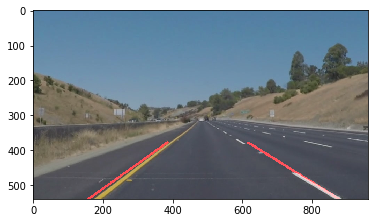

In [3]:
import os
imgs=os.listdir("test_images/")
print(imgs)
image_output_dir="test_images_output/"

for i, fig in enumerate(imgs):
    #Reading in an image
    image = mpimg.imread("test_images/"+fig)
    #Processing image
    print(fig)
    pImg=process_image(image);
    plot=plt.imshow(pImg)
    plt.savefig(image_output_dir+fig, format='jpg', dpi=300)

In [4]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:03<00:00, 61.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 4.1 s


In [5]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:11<00:00, 60.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 11.7 s
